In [1]:
import numpy as np
import deeptrack as dt
import deeplay as dl
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


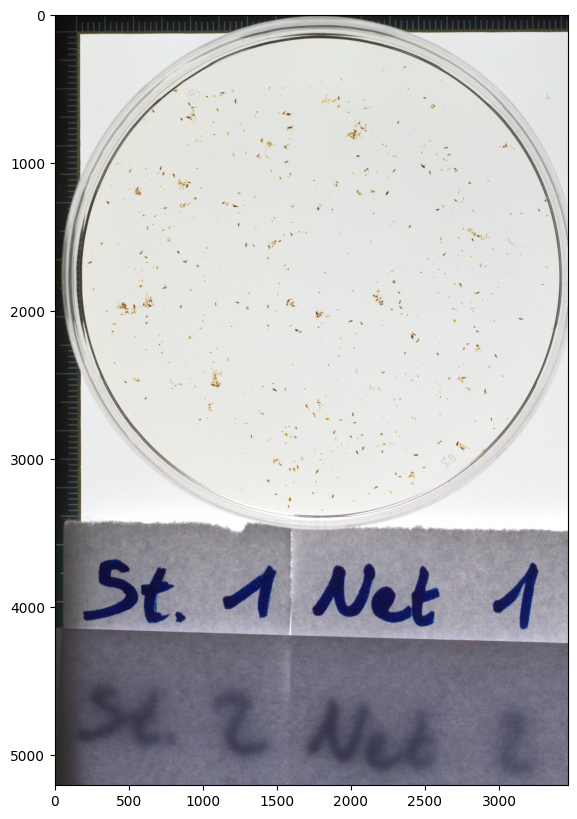

In [2]:
image = dt.LoadImage("cope_1.png")

plt.figure(figsize=(15, 10))
image = np.array(image.resolve()) #Note to self, resolve() makes it into a list
plt.imshow(image)

# Prepare cropped sample

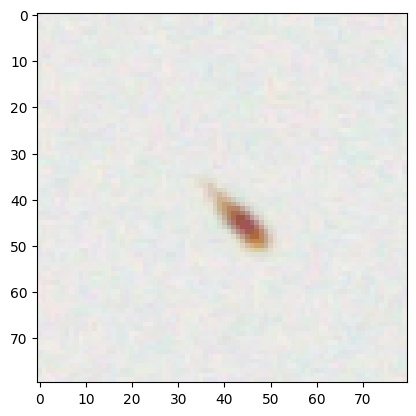

In [34]:
crop_size = 80
y_index = 1870
x_index = 1780


'''
Example crops for cope_1.png:

crop_size = 80
y_index = 1860
x_index = 910

crop_size = 70
y_index = 1970
x_index = 850

'''


x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
crop = np.array(image[x0:x0+crop_size, y0: y0 + crop_size])
plt.imshow(crop)

In [35]:
training_pipeline = (
    dt.Value(crop)
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)
training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, replace=False)

In [36]:
dataloader = dl.DataLoader(training_dataset,batch_size=8,shuffle=True,num_workers=5)

# Train LodeSTAR

In [39]:
epochs = 6
lodestar = dl.LodeSTAR(n_transforms=4,optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=epochs)
trainer.fit(lodestar,dataloader)

INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_lo

Epoch 5: 100%|██████████| 50/50 [00:25<00:00,  1.95it/s, v_num=17, train_between_image_disagreement_step=0.787, train_within_image_disagreement_step=0.123, train_between_image_disagreement_epoch=0.837, train_within_image_disagreement_epoch=0.123]


# Evaluate Performance

Text(0.5, 1.0, 'input + predicted')

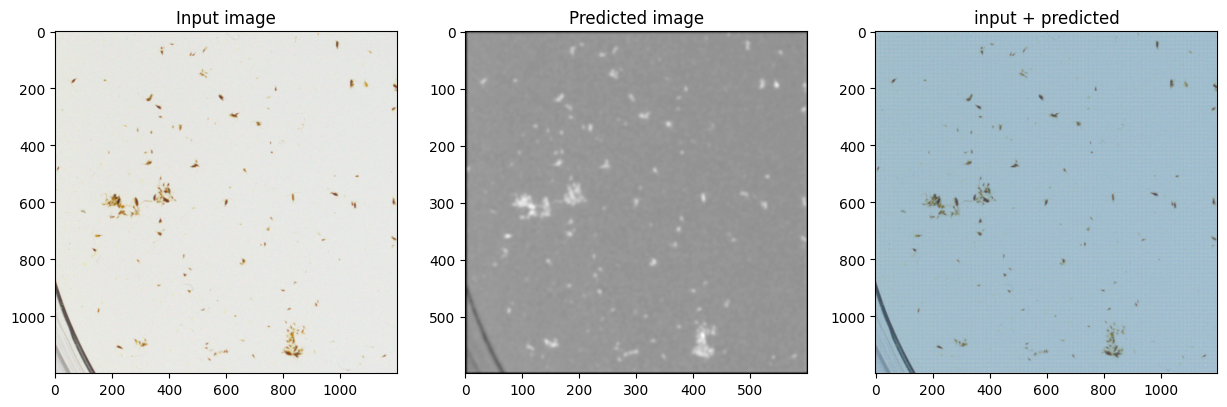

In [40]:
crop_size= 1200
y_index = 1970
x_index = 850

x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
crop = image[x0:x0+crop_size, y0: y0 + crop_size]



torch_image = torch.from_numpy(crop).permute(2,0,1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(crop)
plt.title("Input image")

plt.subplot(1,3,2)
plt.imshow(rho,cmap="grey")
plt.title("Predicted image")

plt.subplot(1,3,3)
plt.imshow(crop)
plt.scatter(y,x,alpha=rho.flatten()/rho.max(),s=0.0005)
plt.title("input + predicted")
